# Perovskites

In this notebook, we demonstrate some of the initial work on this project that was carried out in the summer of 2021. Here, we leverage some Xenonpy-calculated properties to calculate the unit cell volume of several perovskite systems taken from NOMAD's database.

Both SISSO and TPOT are used to train predictive models, and near the end of the document we discuss what we can learn from this comparison.

Overall, in this notebook we demonstrate SISSO's ability to generate simple, interpretable models that can help lead us to physical insight - one of the major strengths of symbolic regression.

In [1]:
import functools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost

import xenonpy.descriptor

import sys

sys.path.append("../../../")
import DigitalEcosystem.utils.figures

from IPython.display import Latex

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Data

Read the data, and featurize using XenonPy

In [3]:
data = pd.read_pickle('../../raw_data/perovskites.pkl')

# Scale volume to have units of Å^3 / formula unit
data["Volume"] /= data["Atoms_Object"].apply(lambda atoms: len(atoms)//5)

# Featurize with XenonPy
cal = xenonpy.descriptor.Compositions()
data["Symbols"] = data.Atoms_Object.apply(lambda atoms: collections.Counter(atoms.get_chemical_symbols()))
featurized_data = pd.concat([data, cal.transform(data.Symbols)], axis=1)

data = featurized_data.drop(columns=['Symbols'])
data

,Formula,Atoms_Object,Volume,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,AgCl3K,"(Atom('K', [2.546784180928994, 2.5467841809289...",132.452162,23.4,164.212290,215.4,22.340,50.663300,849.560,21.280000,...,1.0,3.0,0.237,0.00890,175.0,182.0,207.0,314.8,206.0,2.180
1,La2N6W2,"(Atom('La', [2.665318694121161, 2.857224133724...",65.894295,30.4,120.800000,214.8,16.786,72.953294,1978.440,102.018930,...,2.0,2.0,0.133,0.02583,155.0,166.0,193.0,309.6,333.6,1.100
2,O3SrV,"(Atom('Sr', [1.9322684339857643, 1.93226843398...",57.715487,17.0,157.520852,208.8,16.810,37.311700,1115.514,92.159719,...,2.0,2.0,0.301,0.02658,152.0,150.0,182.0,314.4,317.5,0.802
3,Cl6Cs2Tl2,"(Atom('Cs', [7.926562986915786, 0.0, 0.0289390...",176.625755,37.4,176.012290,221.8,28.660,88.727090,679.480,9.580000,...,1.0,3.0,0.128,0.00890,175.0,182.0,207.0,394.7,206.0,2.180
4,F3MnRb,"(Atom('Rb', [2.1409860345006186, 2.14098603450...",78.511177,17.8,157.014169,194.2,22.918,39.480211,690.206,52.579364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,296.1,1300.0,0.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,F6In2Mn2,"(Atom('In', [3.004706503626541, 3.051648750812...",77.734000,20.2,140.614169,195.4,14.878,45.350251,968.606,67.917949,...,2.0,2.0,0.234,0.02770,147.0,146.0,171.0,296.1,1215.0,0.557
140,CaF3Rb,"(Atom('Rb', [2.259732663194181, 2.259732663194...",92.312641,16.8,169.414169,199.8,27.420,36.508202,594.606,31.979364,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,336.4,1300.0,0.557
141,MoNaO3,"(Atom('Na', [0.0, 0.0, 0.0], index=0), Atom('M...",59.086370,15.4,153.520852,196.4,15.020,33.387354,1262.334,92.923625,...,1.0,2.0,0.251,0.02658,152.0,150.0,182.0,298.3,317.5,0.802
142,KO3W,"(Atom('K', [0.0, 0.0, 0.0], index=0), Atom('W'...",62.178694,23.4,162.920852,200.0,19.366,54.187060,1449.514,108.283625,...,1.0,2.0,0.133,0.02658,152.0,150.0,182.0,309.6,317.5,0.802


# Prepare Data

In [24]:
target_column = ['Volume']
xenonpy_descriptors = [col for col in data.columns if ":" in col]

train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = train[xenonpy_descriptors].to_numpy()
train_y = train[target_column].to_numpy()

test_x = test[xenonpy_descriptors].to_numpy()
test_y = test[target_column].to_numpy()

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

In [9]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=100,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_poisson_deviance(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )

    return score

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-10-04 14:59:22,116] A new study created in memory with name: no-name-72681b69-2f82-4730-8b28-a959ec989b54
[I 2021-10-04 14:59:22,383] Trial 0 finished with value: 23.492229994546662 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 23.492229994546662.
[I 2021-10-04 14:59:22,397] Trial 1 pruned. Trial was pruned at iteration 1.
[I 2021-10-04 14:59:22,637] Trial 2 finished with value: 49.78365344055158 and parameters: {'learning_rate': 0.5030831653078097, 'min_split_loss': 0.013768449590682241, 'max_depth': 78, 'min_child_weight': 8.826411906361166, 'reg_lambda': 0.7297719678027446, 'reg_alpha': 1.2307923568669874, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 23.492229994546662.
[I 2021-10-04 14:59:22,878] Trial 3 finished with value: 3.603764929314155 an

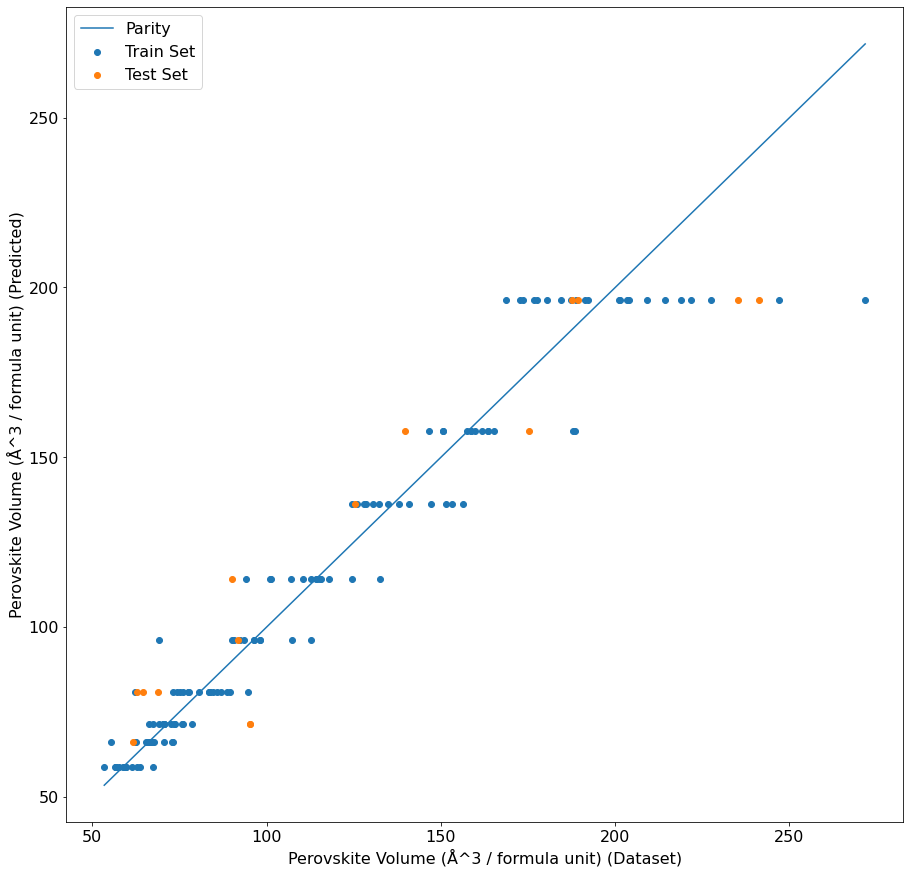

In [12]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x,
                                                test_x,
                                                train_y,
                                                test_y,
                                                best_reg,
                                                "Perovskite Volume (Å^3 / formula unit)",
                                                "xgboost_perovskite_volume_parity.jpeg")

In [20]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 44.9303
MAE 18.184
MSE 459.6107
RMSE 21.4385
MAPE 0.1565
R2 0.8748

Training Set Error Metrics
MaxError 75.2777
MAE 8.1136
MSE 169.8152
RMSE 13.0313
MAPE 0.0647
R2 0.9355


# TPOT

In [7]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.717022046092263

Generation 2 - Current best internal CV score: -4.717022046092263

Generation 3 - Current best internal CV score: -4.717022046092263

Generation 4 - Current best internal CV score: -4.5102759479159085

Generation 5 - Current best internal CV score: -4.5102759479159085

Generation 6 - Current best internal CV score: -4.5102759479159085

Generation 7 - Current best internal CV score: -4.5102759479159085

Generation 8 - Current best internal CV score: -4.5102759479159085

Generation 9 - Current best internal CV score: -4.506486960757288

Generation 10 - Current best internal CV score: -4.493654315122452

Best pipeline: RidgeCV(MinMaxScaler(CombineDFs(input_matrix, SelectFwe(input_matrix, alpha=0.009000000000000001))))


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


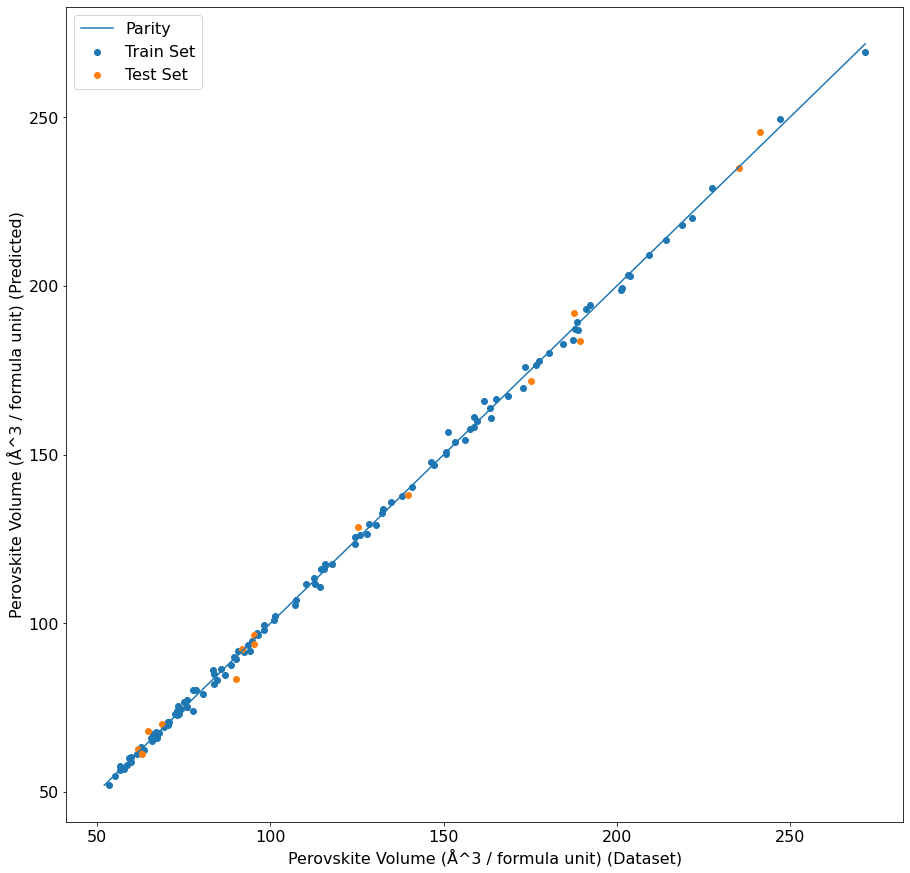

In [8]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x,
                                                test_x,
                                                train_y,
                                                test_y,
                                                tpot_model,
                                                "Perovskite Volume (Å^3 / formula unit)",
                                                "xgboost_perovskite_volume_parity.jpeg")

In [21]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 6.3668
MAE 2.6367
MSE 10.2821
RMSE 3.2066
MAPE 0.0231
R2 0.9972

Training Set Error Metrics
MaxError 5.4745
MAE 1.0702
MSE 2.0303
RMSE 1.4249
MAPE 0.01
R2 0.9992


# Roost

In [39]:
import os
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)

roost_data_train = train[['Formula', 'Volume']]
roost_data_test = test[['Formula', 'Volume']]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'))
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'))

# SISSO

# SISSO Models
Here, we have Rung1 and Rung2 models that have been generated by SISSO using the XenonPy compositional descriptors. 

In [ ]:
models = {
    "r1_1term": lambda df: 2.342082515585748e-02 + \
                           5.172456498122173e-01 * (df["ave:vdw_radius_uff"] + df["ave:covalent_radius_pyykko_double"]),
    "r1_2term": lambda df: 1.052443572291616e-02 + \
                           1.242091145866421e-01 * (df["ave:num_p_valence"] + df["ave:num_p_unfilled"]) + \
                           4.898720001428966e-01 * (df["min:gs_volume_per"] + df["ave:covalent_radius_pyykko_double"]),
    "r2_1term": lambda df: 4.521699008847579e-03 + \
                           2.966651096729857e-01 * (
                                   (df["min:Polarizability"] + df["ave:num_p_valence"]) + \
                                   (df["min:gs_volume_per"] + df["ave:vdw_radius_mm3"])
                           )
}

data_train_scaled_sisso = data_train_scaled.copy()
data_test_scaled_sisso = data_test_scaled.copy()
for key, fun in models.items():
    data_train_scaled_sisso[key] = fun(data_train_scaled_sisso)
    data_test_scaled_sisso[key] = fun(data_test_scaled_sisso)

data_train_scaled_sisso.head()

# TPOT Model

To have something to compare to, we'll also run a TPOT model for 10 minutes.

In [ ]:
# TPOT with the vanilla features

model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=1 / 60,
    max_time_mins=10,
    cv=len(data_train_scaled),
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

In [ ]:
train_x = data_train_scaled.drop(columns="Volume").to_numpy()
train_y = data_train_scaled.Volume.to_numpy().ravel()

test_x = data_test_scaled.drop(columns="Volume").to_numpy()
test_y = data_test_scaled.Volume.to_numpy().ravel()



## TPOT Pipeline
TPOT Generates the following pipeline:
1. Decision Tree Regressor
2. The decision tree's predictions are scaled to be between 0 and 1.
3. Ridge regression is used on this scaled set of predictions.

## TPOT Model Plot

In [ ]:
def unscale(arr):
    return arr * std["Volume"] + mean["Volume"]


train_pred_y = model.predict(train_x)
test_pred_y = model.predict(test_x)

create_parity_plot_with_raw_values = functools.partial(DigitalEcosystem.utils.figures.save_parity_plot_with_raw_values,
                                                       train_y=unscale(train_y),
                                                       test_y=unscale(test_y))

create_parity_plot_with_raw_values(unscale(train_pred_y),
                                   unscale(test_pred_y),
                                   filename='tpot_parity.png')

# SISSO Rung1, 1-Term Plot

In [ ]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r1_1term"]),
                                   unscale(data_test_scaled_sisso["r1_1term"]),
                                   filename='sisso_r1_1t_parity.png')

# SISSO Rung1, 2-Term Plot

In [ ]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r1_2term"]),
                                   unscale(data_test_scaled_sisso["r1_2term"]),
                                   filename='sisso_r1_2t_parity.png')

# SISSO Rung2, 1-Term Plot

In [ ]:
create_parity_plot_with_raw_values(unscale(data_train_scaled_sisso["r2_1term"]),
                                   unscale(data_test_scaled_sisso["r2_1term"]),
                                   filename='sisso_r2_1t_parity.png')

# Combined Plots

Finally, we compare the results of the SISSO models and the TPOT model.

## Training Set

Below, we plot the Training set results for:
1. The TPOT model (Black + symbols)
2. The SISSO Rung1, 1-Term Model (Red Nablas / Upside-Down Triangles)
3. The SISSO Rung1, 2-Term Model (Green Deltas / Rightside-Up Triangles)
4. The SISSO Rung2, 1-Term Model (Blue Squares)

As a guide to the eye, parity is also drawn as a dashed black line.

In [ ]:
tpot_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y),  y_pred=unscale(train_pred_y)),2)
r1_1t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_1term"])), 2)
r1_2t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_2term"])), 2)
r2_1t_mape = np.round(sklearn.metrics.mean_absolute_percentage_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r2_1term"])), 2)

alphas = (0.9, 0.5, 0.5, 0.5)
markers = '+v^s'
colors=('black','red', 'green', 'blue')
labels=(f"TPOT, 108 Terms, MAPE={tpot_mape}",
        f"Rung 1, 1-Term, MAPE={r1_1t_mape}",
        f"Rung 1, 2-Term, MAPE={r1_2t_mape}",
        f"Rung 2, 1-term, MAPE={r2_1t_mape}")

DigitalEcosystem.utils.figures.create_multi_parity_plot(ytrue=unscale(train_y), 
                                                        series_to_plot = map(unscale, (train_pred_y, 
                                                                                       data_train_scaled_sisso['r1_1term'],
                                                                                       data_train_scaled_sisso['r1_2term'],
                                                                                       data_train_scaled_sisso['r2_1term'])
                                                                            ),
                                                        markers=markers,
                                                        alphas=alphas,
                                                        colors=colors,
                                                        labels=labels,
                                                        is_train=True)

## Test-Set
Below, we plot the Training set results for:
1. The TPOT model (Black + symbols)
2. The SISSO Rung1, 1-Term Model (Red Nablas / Upside-Down Triangles)
3. The SISSO Rung1, 2-Term Model (Green Deltas / Rightside-Up Triangles)
4. The SISSO Rung2, 1-Term Model (Blue Squares)

As a guide to the eye, parity is also drawn as a dashed black line.

In [ ]:
DigitalEcosystem.utils.figures.create_multi_parity_plot(ytrue=unscale(test_y), 
                                                        series_to_plot = map(unscale, (test_pred_y, 
                                                                                       data_test_scaled_sisso['r1_1term'],
                                                                                       data_test_scaled_sisso['r1_2term'],
                                                                                       data_test_scaled_sisso['r2_1term'])
                                                                            ),
                                                        markers=markers,
                                                        alphas=alphas,
                                                        colors=colors,
                                                        labels=labels,
                                                        is_train=False)

# Conclusions

Overall, we find that SISSO creates models that are much simpler than the TPOT pipeline, while being nearly as performant. Generally, they seem to rely heavily on atomic volume descriptors.

Although this may initially seem like an obvious result (as naturally, the crystal cell should correlated with the atomic volumes contained within), keep in mind that SISSO took in no other information about this result. Moreover, it generates easy-to-interpret linear models that give the user "knobs" that can be turned to effect some result.

Contrast with the TPOT model, which contains a decision tree followed by some postprocessing followed by ridge regression. This model is essentially a black box - although the decision trees are generally interpretable, we're also heavily postprocessing it. Morevoer, a decision tree is an interpolative model, which means we'd be unable to extrapolate. The decision tree also takes in over 100 features.

Contrary to this limitation, the SISSO model will extrapolate, takes in just 2-4 features (depending on the rung and number of terms), and results to something that's very close to the conventional wisdom a chemist might offer.

Overall, although the TPOT model performs *slightly* better, the SISSO model has more utility if one seeks to obtain physical insight.